---
layout: post
title: Performance shootout - python libraries for computer vision (Part 2/2)
excerpt: Did a little performance comparison for different image processing/computer vision libraries for computing different kinds of features from image
---

**Update 2017-02-03**

Updated to latest versions of OpenCV/mahotas/skimage
---

In the last post, we benchmarked of three different libraries for performing simple morphological operations on images. Current post covers benchmarks for more computation intensive operations like computing texture features of an image. Such features, for example, [haralick](http://murphylab.web.cmu.edu/publications/boland/boland_node26.html) features, [zernike](https://en.wikipedia.org/wiki/Zernike_polynomials) moments, [hu](https://www.youtube.com/watch?v=O-hCEXi3ymU) moments describe various aspects of image like texture, shape, patterns and are still often used for classification and tagging purposes

## 1. Boilerplate Stuff

Like before, we'll define some basic functions for plotting. Also specifying some image paths (modify them as necessary)

In [18]:
import sys, os, random
import numpy as np
import timeit
import cv2, mahotas, skimage, skimage.feature, skimage.measure
from skimage.feature import local_binary_pattern
from mahotas.features.lbp import lbp_transform

import matplotlib.pyplot as plt
%matplotlib inline

ImagePath = 'brodatz/'

def pyplots(images, titles=None):
    num = len(images)
    plt.figure(figsize=(15,6))
    for index, im in enumerate(images):
        plt.subplot(2, num/2, index+1)
        plt.imshow(im, cmap='gray')
        if titles is None:
            plt.title('%d'%(index))
        else:
            plt.title(str(titles[index]))
        plt.axis('off')

### Sample Images

Here are some of the images from Broadtz dataset

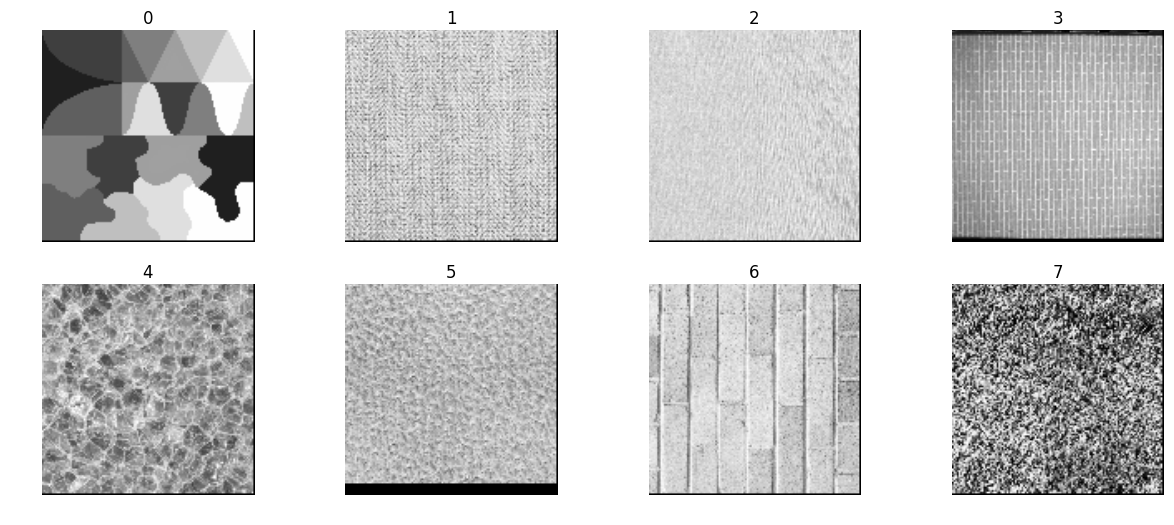

In [4]:
images = os.listdir(ImagePath)

testIdx = 40
testImg = mahotas.imresize(mahotas.imread(os.path.join(ImagePath,images[testIdx])), (128,128)).astype(np.int32)
allImg = [mahotas.imresize(mahotas.imread(os.path.join(ImagePath,im)), (128, 128)).astype(np.int32) for im in images]

sample = random.sample(allImg,8)
pyplots(sample)

### Comparison

In order to see how good or bad a particular feature set is performing, we will compute k-nearest neighbors for given image from whole of the dataset. I am using ```cv2.HISTCMP_CORREL``` for computing distances between representation (feature vectors) of two images. To be honest, this method doesn't perform well in most of the cases. Different distances might be relevant depending on the dataset and algorithm you use for computing features. Here we will just stick to one of the meterics for sanity.

I might write a separate blog post comparing distance meterics. Stay tuned.

In [ ]:
def kNN(srcVec, destVecs, k=7, method=cv2.HISTCMP_CORREL, absolute=True, reverse=False):
    distances = []
    srcVec = srcVec.flatten().astype(np.float32)
    for destVec in destVecs:
        distance = cv2.compareHist(srcVec, destVec.flatten().astype(np.float32), method=method)
        distances.append(distance)
    
    if absolute:
        distances = np.absolute(distances)
        
    if reverse:
        sortedIdx = np.argsort(distances)[-k:][::-1]
    else:
        sortedIdx = np.argsort(distances)[:k]
        
    return sortedIdx, [distances[idx] for idx in sortedIdx]

## haralick features

Haralick features date back to as far as 1970s and were one of the first used to classify aerial imagery collected from satellites.

The idea behind haralick feature extraction is to 
* compute **co-occurance matrix** from the image (generated by counting the number of times a pixel with value *i* is adjacent to a pixel with value *j*)
* Compute statistics of the matrix like contrast, correlation, variation etc.

### mahotas

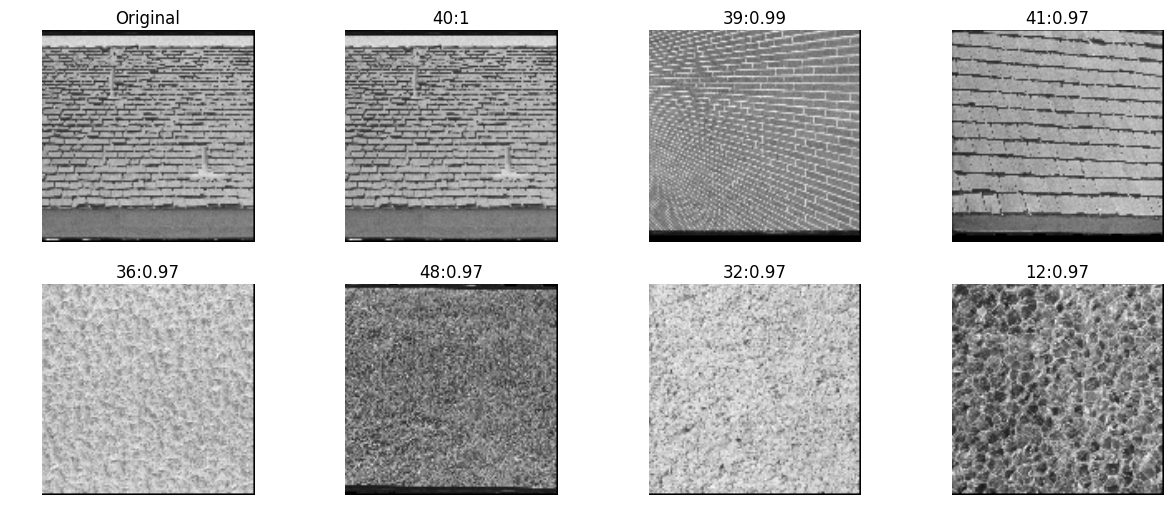

In [5]:
inVector = mahotas.features.haralick(testImg)
allVectors = [mahotas.features.haralick(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

### skimage

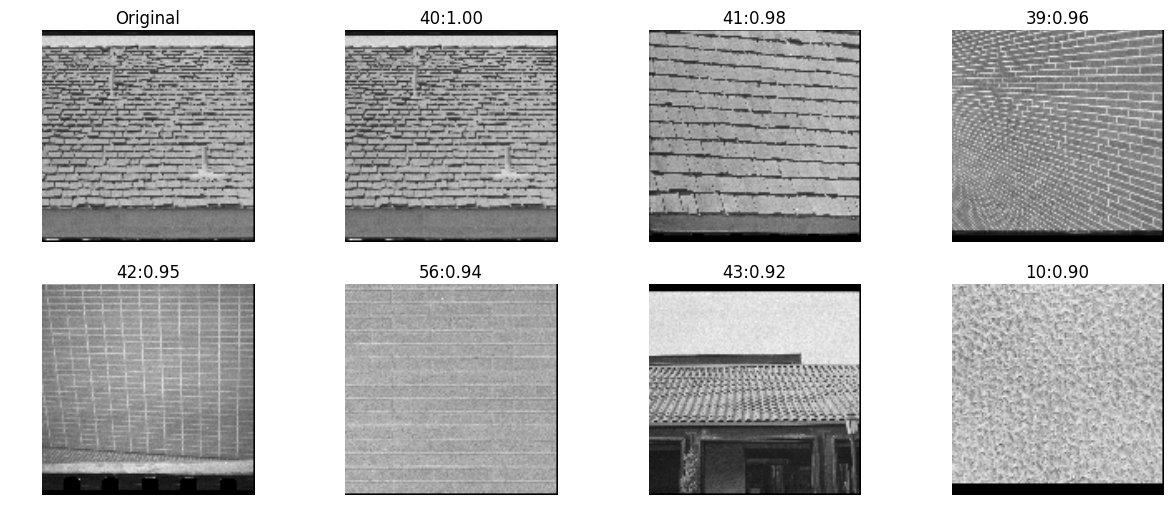

In [6]:
def haralick_sk(img):
    g = skimage.feature.greycomatrix(img, range(4), np.pi/4*np.arange(4), levels=256, symmetric=True, normed=True)
    return skimage.feature.greycoprops(g)
    
inVector = haralick_sk(testImg)
allVectors = [haralick_sk(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2f'%(idx, distance) for idx,distance in zip(nn,distances)])

## zernike moments

Zernike polynomials are a sequence of polynomials that are orthogonal on the unit disk. There is a theorem that says any sufficiently smooth real-valued phase field over the unit disk can be represented in terms of its Zernike coefficients (odd and even), just as periodic functions find an orthogonal representation with the Fourier series.

[Refer](http://murphylab.web.cmu.edu/publications/boland/boland_node25.html) - In order to convert a rectangular region of each image to a unit circle for calculation of Zernike moments - 

* First, the "center of fluorescence" (analogous to the center of mass) for each image was calculated and used to define the center of the pixel coordinate system. 
* Second, the x and y coordinates were divided by 150 (this corresponds to the size of an average cell at the magnification used in these experiments). Only pixels within the unit circle of the resulting normalized image, f(x,y), were used for subsequent calculations


### mahotas

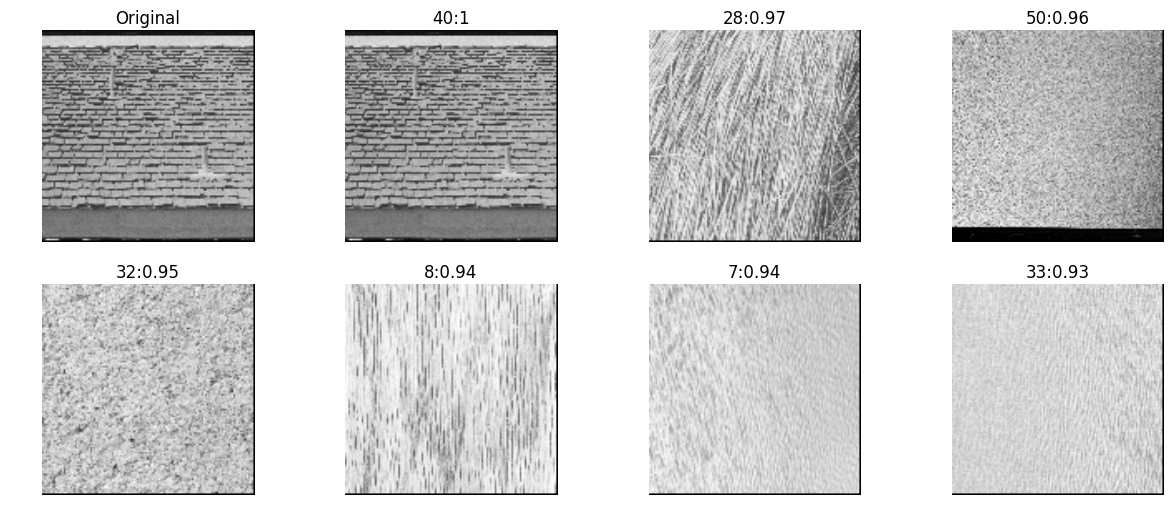

In [7]:
inVector = mahotas.features.zernike_moments(testImg, radius=5)
allVectors = [mahotas.features.zernike_moments(img, radius=5) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## hu moments

An image moment is a certain particular weighted average (moment) of the image pixels' intensities.

Hu Moments are typically used to describe properties of objects (and shaped) in the image after segmentation. They are not particulary relevant for describing texture. Just keeping them here for speed comparison.

### skimage

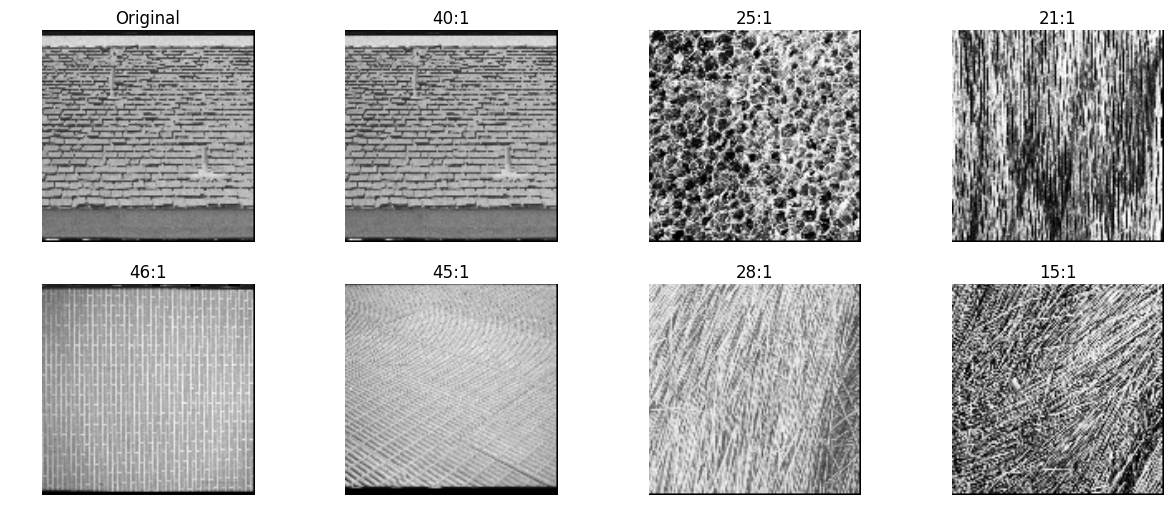

In [8]:
def hu_moments_sk(img):
    img = img.astype(np.uint8)
    raw_m = skimage.measure.moments(img)
    cr = raw_m[0, 1] / raw_m[0, 0]; cc = raw_m[1, 0] / raw_m[0, 0]
    central_m = skimage.measure.moments_central(img, cr, cc)
    norm_m = skimage.measure.moments_normalized(central_m)
    return skimage.measure.moments_hu(norm_m)

inVector = hu_moments_sk(testImg)
allVectors = [hu_moments_sk(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

### opencv

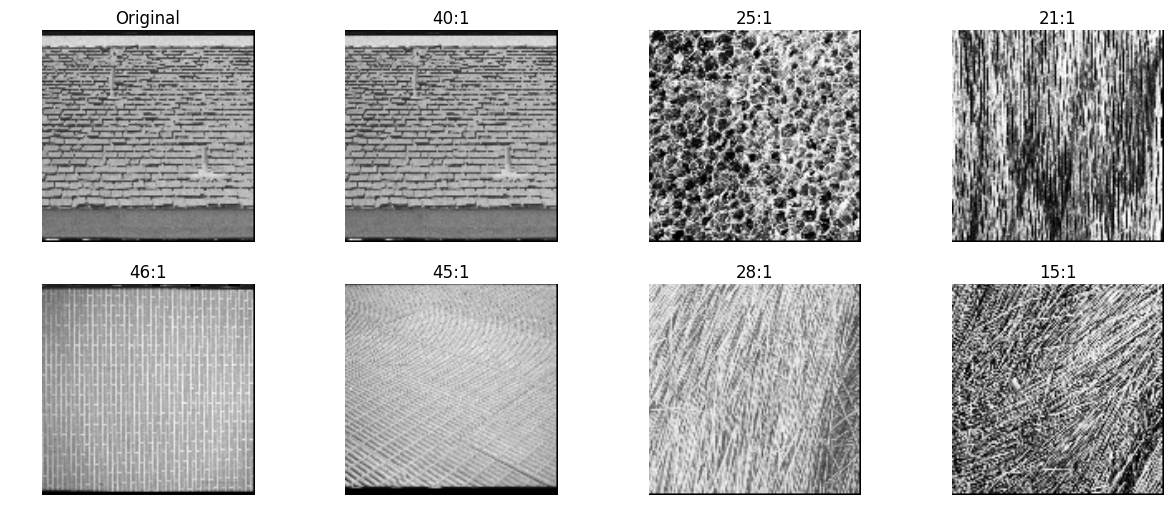

In [9]:
def hu_moments_cv(img):
    img = img.astype(np.uint8)
    m = cv2.moments(img)
    return cv2.HuMoments(m)

inVector = hu_moments_cv(testImg)
allVectors = [hu_moments_cv(img) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## local binary patterns

Developed in early 1990s, Local binary patterns (LBP) were commonly used for image classification before deep learning storm.

[Ref](https://en.wikipedia.org/wiki/Local_binary_patterns) - In LBP, each image is divided into cells (say 16x16 pixels) and a histogram is computed for each cell as following
* Compare the pixel in each cell to each of its 8 neighbors (on its left-top, left-middle, left-bottom, right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise.
* Where the center pixel's value is greater than the neighbor's value, write "0". Otherwise, write "1". This gives an 8-digit binary number (which is usually converted to decimal for convenience).
* Compute the histogram, over the cell, of the frequency of each "number" occurring (i.e., each combination of which pixels are smaller and which are greater than the center). This histogram can be seen as a 256-dimensional feature vector.
* Optionally normalize the histogram.

Feature vector of an image is a concatenated version of these histograms

### mahotas

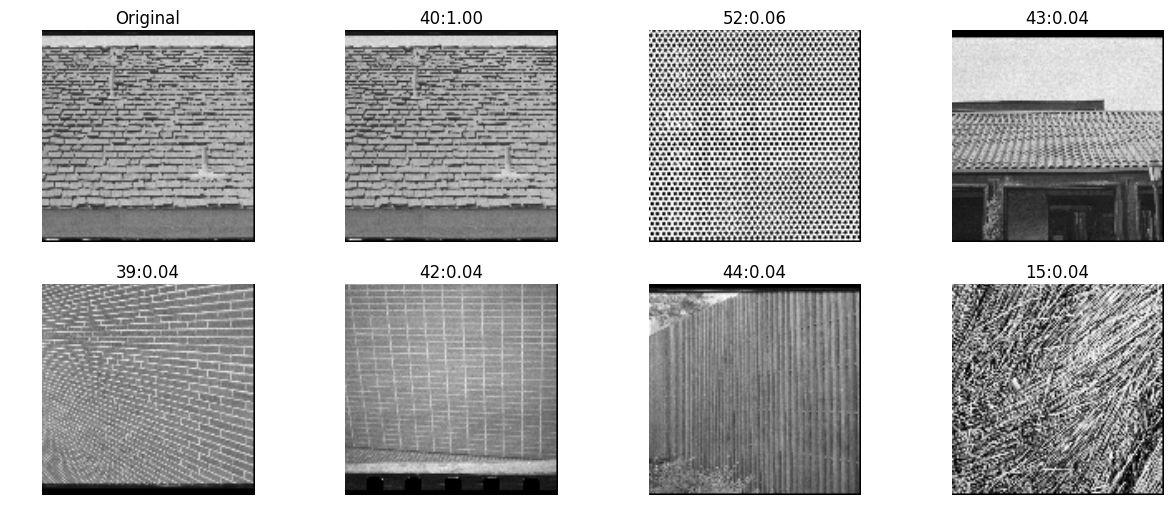

In [10]:
inVector = lbp_transform(testImg, radius=2, points=16)
allVectors = [lbp_transform(img, radius=2, points=16) for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2f'%(idx, distance) for idx,distance in zip(nn,distances)])

### skimage

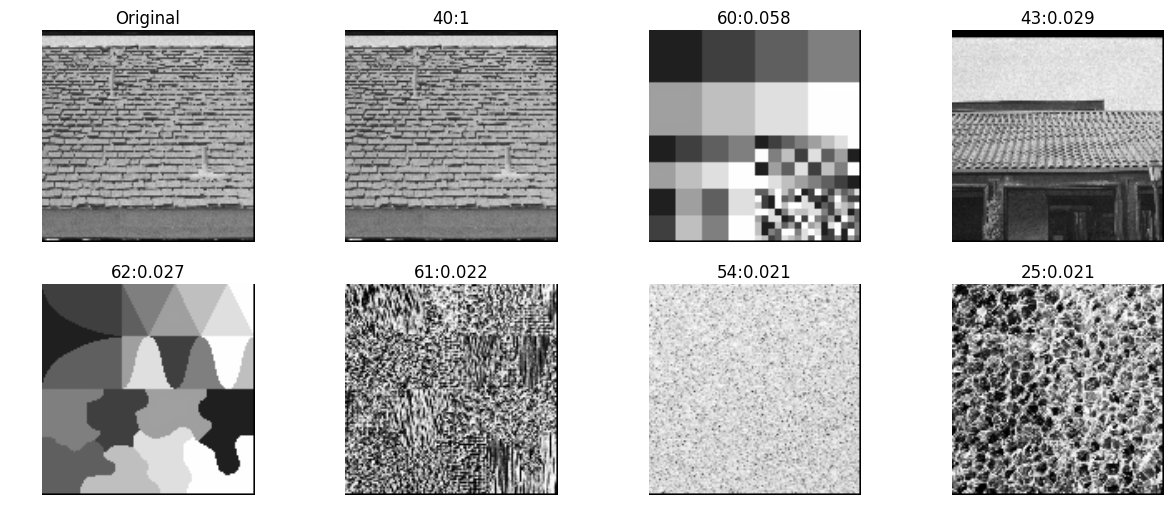

In [11]:
inVector = local_binary_pattern(testImg, 16, 2, 'uniform')
allVectors = [local_binary_pattern(img, 16, 2, 'uniform') for img in allImg]

nn, distances = kNN(inVector, allVectors, reverse=True)

pyplots([testImg] + [allImg[idx] for idx  in nn], 
        titles=['Original']+['%d:%.2g'%(idx, distance) for idx,distance in zip(nn,distances)])

## mahotas vs skimage vs opencv

In [15]:
pre ='''
import os
import numpy as np
import cv2, mahotas, skimage, skimage.feature, skimage.measure
from skimage.feature import local_binary_pattern
from mahotas.features.lbp import lbp_transform

ImagePath = 'brodatz/'
images = os.listdir(ImagePath)
testImg = mahotas.imresize(mahotas.imread(os.path.join(ImagePath,images[40])), (128,128)).astype(np.int32)
testImg8 = testImg.astype(np.uint8)

def haralick_sk(img):
    g = skimage.feature.greycomatrix(img, range(4), np.pi/4*np.arange(4), levels=256, symmetric=True, normed=True)
    return skimage.feature.greycoprops(g)
    
def hu_moments_sk(img):
    raw_m = skimage.measure.moments(img)
    cr = raw_m[0, 1] / raw_m[0, 0]; cc = raw_m[1, 0] / raw_m[0, 0]
    central_m = skimage.measure.moments_central(img, cr, cc)
    norm_m = skimage.measure.moments_normalized(central_m)
    return skimage.measure.moments_hu(norm_m)
    
def hu_moments_cv(img):
    m = cv2.moments(img)
    return cv2.HuMoments(m)

'''

In [21]:
def t(s):
    return timeit.timeit(s, setup=pre, number=10)

tests = [
    ('haralick', [
        'mahotas.features.haralick(testImg)',
        'haralick_sk(testImg)',
        None,
        ]),
    ('zernike', [
        'mahotas.features.zernike_moments(testImg, radius=5)',
        None,
        None,
        ]),
    ('hu', [
        None,
        'hu_moments_sk(testImg8)',
        'hu_moments_cv(testImg8)',
        ]),
    ('lbp', [
        'lbp_transform(testImg, radius=3, points=24)',
        'local_binary_pattern(testImg, 24, 3, "uniform")',
        None,
        ]),
]

print(r'%-12s|%9s |%9s |%9s |' % ('Algorithm', 'mahotas','skimage','opencv'))
for name,statements in tests:
    sys.stdout.write(r'%-12s|' % name)
    for st in statements:
        if st is None:
            sys.stdout.write('      NA |')
        else:
            time = '%.4f' % (t(st))
            sys.stdout.write('%8s |' % time)
    sys.stdout.write('\n')


Algorithm   |  mahotas |  skimage |   opencv |
haralick    |  0.1879 |  0.2082 |      NA |
zernike     |  0.0093 |      NA |      NA |
hu          |      NA |  0.0069 |  0.0003 |
lbp         |  0.2269 |  0.1078 |      NA |


Here it is! While OpenCV is blazingly faster than other libraries, a lot of implementations seems missing (at least in the python API of OpenCV). **`skimage`** would be a good alternate with lot of algorithms ready to be played with